In [1]:
!pip install ftfy regex tqdm matplotlib opencv-python scipy scikit-image
!pip install git+https://github.com/openai/CLIP.git

import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import cv2
import urllib.request
import matplotlib.pyplot as plt
import clip
from PIL import Image
from skimage import transform as skimage_transform
from scipy.ndimage import filters

image_url = '(2).jpg'
image_caption = 'sunflower'
clip_model = "RN101" #Image Encoder
saliency_layer = "layer4"
blur = True

     |████████████████████████████████| 64 kB 1.4 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=700665ace164b473bde7bfeed4fbb10e83610eb76bb9a34267e0ad4e09d21922
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hsfmv2z1
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-hsfmv2z1
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=84876d56e04a456fd7135644a374a600492977c2de5c07bbe5410167b4de5b53
  Stored in directory: /tmp/pip-ephem-wheel-cache-39wh6srk/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
def normalize(x: np.ndarray) -> np.ndarray:
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, blur=True):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()
    
def load_image(img_path, resize=None):
    image = Image.open(image_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

In [3]:
class Hook:

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)
        
    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()
        
    @property
    def activation(self) -> torch.Tensor:
        return self.data
    
    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad

In [4]:
def gradCAM(
    model: nn.Module, input: torch.Tensor, target: torch.Tensor,
    layer: nn.Module) -> torch.Tensor:
    if input.grad is not None:
        input.grad.data.zero_()
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:        
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        gradcam = torch.clamp(gradcam, min=0)

    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)

    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])
        
    return gradcam

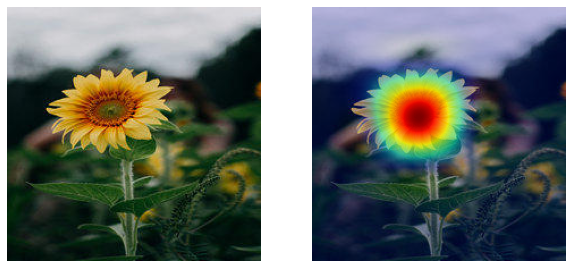

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

try:
  image_path = 'image.png'
  urllib.request.urlretrieve(image_url, image_path)
except ValueError:
  image_path = image_url
image_input = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image_np = load_image(image_path, model.visual.input_resolution)
text_input = clip.tokenize([image_caption]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)